# Clustering our Data
We want to pull outliers from a dataset and organize them into separate folders.


In [1]:
try:
    from cuml.manifold.Tumap import UMAP
    print('[INFO]: Using cuml UMAP')
except:
    from umap import UMAP
    print('[INFO]: CUML not available; using umap-learn UMAP')

import plotly.express as px
import pandas as pd
import hdbscan
import pickle
import shutil
import os

[INFO]: CUML not available; using umap-learn UMAP


In [2]:
saveFolder = '/home/umar-musashi/Documents/repos/working/Content-Based-Image-Retrieval/src/assets/resources/'
with open(saveFolder + 'lobe_all_imgs_features.pickle', 'rb') as f:  features = pickle.load(f)
# img_paths used below with FAISS code
with open(saveFolder + 'lobe_all_imgs_img_paths.pickle', 'rb') as f:  img_paths = pickle.load(f)

# `UMAP` Dimensionality Reduction & `HDBSCAN` Clustering

In [11]:
clusterable_embedding_2d = UMAP(
    n_neighbors=100,
    min_dist=0.00,
    n_components=2,
    metric="correlation",
    random_state=24,
    transform_seed=24,
).fit_transform(features)

clusterable_embedding_3d = UMAP(
    n_neighbors=100,
    min_dist=0.00,
    n_components=3,
    metric="correlation",
    random_state=24,
    transform_seed=24,
).fit_transform(features)

In [22]:
clusterable_embedding_3d[:,1]

array([7.9798756, 7.717861 , 8.185586 , ..., 7.3340573, 9.671202 ,
       9.756893 ], dtype=float32)

In [14]:
labels_3d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=250,
).fit_predict(clusterable_embedding_3d)

labels_2d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=250,
).fit_predict(clusterable_embedding_2d)

In [15]:
fig_2d = px.scatter(
    clusterable_embedding_2d, x=0, y=1,
    color=labels_2d, labels={'color': 'cluster'}
)
fig_2d.show()

In [16]:
fig_2d_3dLabels = px.scatter(
    clusterable_embedding_2d, x=0, y=1,
    color=labels_3d, labels={'color': 'cluster'}
)
fig_2d_3dLabels.show()

In [168]:
saveDirectory = "/home/umar-musashi/Documents/repos/Content-Based-Image-Retrieval/resources/LobeFeatures"
pickle.dump(clusterable_embedding_3d, open(saveDirectory+f"/lobe-clusterable_embedding_3d.pickle", 'wb'))
pickle.dump(labels_2d, open(saveDirectory+f"/lobe-labels_2d.pickle", 'wb'))
pickle.dump(df, open(saveDirectory+f"/lobe-df.pickle", 'wb'))

In [30]:
fig_3d = px.scatter_3d(
    clusterable_embedding_3d, x=0, y=1, z=2,
    color=labels_2d, labels={'color': 'cluster'}
)

fig_3d.update_traces(marker_size=2)

fig_3d.show()

In [31]:
fig_3d = px.scatter_3d(
    clusterable_embedding_3d, x=0, y=1, z=2,
    color=labels_3d, labels={'color': 'cluster'}
)

fig_3d.update_traces(marker_size=2)

fig_3d.show()

In [89]:
clustered = (labels_3d >= 0)
percent_clustered = round(100 * np.sum(clustered) / len(img_paths), 1)
print(f"[INFO]: Percentage of data clustered = {percent_clustered}%")

[INFO]: Percentage of data clustered = 96.5%


In [128]:
# Export clusters to folders
imgs_with_clusters = [[labels_2d[i],img_paths[i][0]] for i in range(len(labels_2d))]

df = pd.DataFrame(imgs_with_clusters,
                columns=['cluster', 'imgPath'],
                index=range(len(labels_2d)))

df

,cluster,imgPath
0,4,/home/umar-musashi/Documents/Musashi Part Imag...
1,4,/home/umar-musashi/Documents/Musashi Part Imag...
2,4,/home/umar-musashi/Documents/Musashi Part Imag...
3,4,/home/umar-musashi/Documents/Musashi Part Imag...
4,1,/home/umar-musashi/Documents/Musashi Part Imag...
...,...,...
5916,4,/home/umar-musashi/Documents/Musashi Part Imag...
5917,4,/home/umar-musashi/Documents/Musashi Part Imag...
5918,4,/home/umar-musashi/Documents/Musashi Part Imag...
5919,0,/home/umar-musashi/Documents/Musashi Part Imag...


In [110]:
def filename(str):
    return str.split('/')[-1]

In [165]:
# First add the noise cluster to the list then the remaining clusters as lists
clusters_dict = {}
cluster_noise = df[df['cluster'] == -1]['imgPath'].tolist()
clusters_dict['cluster_noise'] = cluster_noise

for i in range(len(set(labels_2d))-1):
    subFrame = df[df['cluster'] == i]
    clusters_dict["cluster_%s" %i] = subFrame['imgPath'].tolist()

output_dir = '/home/umar-musashi/Documents/Musashi Part Images/lobe_clusters/'

for cluster in clusters_dict:
    # create a folder for the current cluster
    current_output_dir = os.path.join(output_dir, str(cluster))
    os.makedirs(current_output_dir, exist_ok=True)
    # copy images from original location to new folder
    for path in clusters_dict[str(cluster)]:
        shutil.copy(path, current_output_dir)
    

In [159]:
for cluster in clusters_dict:
    print(cluster)

cluster_noise
cluster_0
cluster_1
cluster_2
cluster_3
cluster_4
cluster_5


# Image Similarity Search using Faiss

In [4]:
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import faiss

In [9]:
# Helper function to get the classname from image path
def classname(str):
    return str.split('/')[-2]

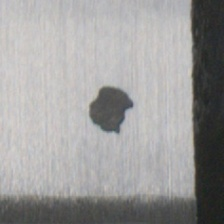

In [4]:
query_image = '/home/umar-musashi/Downloads/GJKZA21201130103JT4E_55_lobe_bot_2021_07_20_13_58_34_0_.jpg'

# query_image = test_img_paths[1][0]
# print(query_image)
# print(classname(query_image))
PIL_img = Image.open(query_image)
PIL_img = PIL_img.convert('RGB')
PIL_img

In [7]:
from collections import Mapping, Container
from sys import getsizeof

def deep_getsizeof(o, ids):
    """Find the memory footprint of a Python object

    This is a recursive function that drills down a Python object graph
    like a dictionary holding nested dictionaries with lists of lists
    and tuples and sets.

    The sys.getsizeof function does a shallow size of only. It counts each
    object inside a container as pointer only regardless of how big it
    really is.

    :param o: the object
    :param ids:
    :return:
    """
    d = deep_getsizeof
    if id(o) in ids:
        return 0

    r = getsizeof(o)
    ids.add(id(o))

    if isinstance(o, str) or isinstance(0, str):
        return r

    if isinstance(o, Mapping):
        return r + sum(d(k, ids) + d(v, ids) for k, v in o.iteritems())

    if isinstance(o, Container):
        return r + sum(d(x, ids) for x in o)

    return r 


/tmp/ipykernel_2726/2469470747.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, Container


In [8]:
# Add trained features to FAISS index

index = faiss.IndexFlatL2(2048)
index.add(features)

print(type(index))
print(deep_getsizeof(index, set()), "bytes")
print(deep_getsizeof(features, set()), "bytes")

<class 'faiss.swigfaiss.IndexFlatL2'>


NameError: name 'unicode' is not defined

/home/umar-musashi/venv/torchgpu/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Using Deivce: cuda


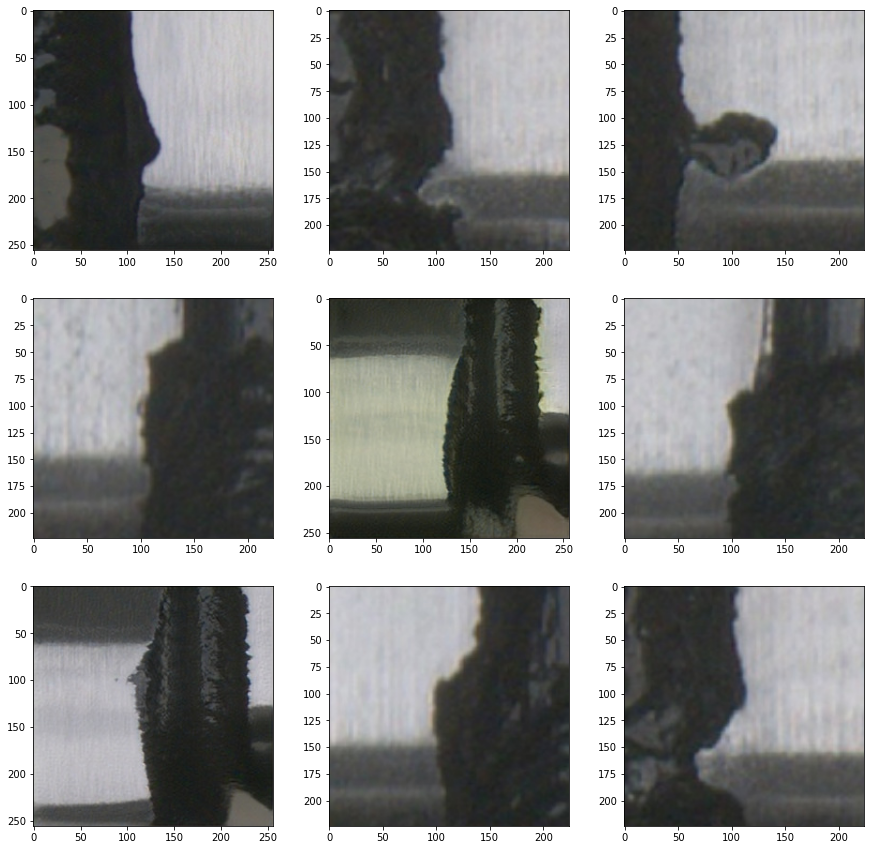

In [6]:
# transform = transforms.Compose(
#             [transforms.Resize(256),
#             transforms.CenterCrop(224),
#              transforms.RandomHorizontalFlip(),
#              transforms.ToTensor(),
#              transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225]),
#              ])

transform = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using Deivce:", DEVICE)
model = models.resnet50(pretrained=True)
model.to(DEVICE)

def pooling_output(x):
  global model
  for layer_name, layer in model._modules.items():
    x = layer(x)
    if layer_name == 'avgpool':
      break
  return x

input_tensor = transform(PIL_img)
input_tensor = input_tensor.view(1, *input_tensor.shape)

# The above lines should not be in this notebook/script

with torch.no_grad():
  query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
  distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)

# truePositives = 0
# falsePositives = 0

# for file_index in indices[0]:
#   sim_img_class = classname(img_paths[file_index][0])
#   # print(sim_img_class)
#   # if class is the same truePositives+=1 else falsePositives+=1 
#   if sim_img_class == classname(query_image):
#     truePositives = truePositives + 1
#   else:
#     falsePositives = falsePositives + 1
# # outside of for loop calculate the recall and output it
# precision = truePositives/(truePositives+falsePositives)
# print("Input Class:",classname(query_image))
# print("TruePositives:",truePositives)
# print("FalsePositives:",falsePositives)
# print("Precision:", round(precision*100,2))
# print("indices:", indices)

fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
  ax_i.imshow(plt.imread(img_paths[file_index]))
  # ax_i.text(0,-2,classname(img_paths[file_index][0]))

plt.show()

In [ ]:
'''
Coding Plan:
- import the pickle variable of extracted features for the dataset
- cluster the data
- pca then visualise the clusters using t-sne

when done:
- add u-map for visualisation as well
'''